In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm, tqdm_notebook

import numpy as np

from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets 
from torchvision import transforms

# General settings and normalization tools

In [2]:
do_train          = True
do_eval           = True
model_path        = '../models/CIFAR_CNN.pt'
batch_size        = 128
device            = torch.device('cuda')
means             = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
stds              = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
normalize         = lambda x: (x - means) / stds
normalize_red     = lambda x: (x - means[0]) / stds[0]
normalize_green   = lambda x: (x - means[1]) / stds[1]
normalize_blue    = lambda x: (x - means[2]) / stds[2]
reverse_normalize = lambda x: (x * stds) + means

In [3]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img.squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.imshow(img_data(img))    

# Data loading

In [4]:
cifar_cats = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [5]:
train_dataset = datasets.CIFAR10(
    '../data',
    train = True,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle = True,
    batch_size = batch_size
)

Files already downloaded and verified


In [6]:
test_dataset = datasets.CIFAR10(
    '../data',
    train = False,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle = False,
    batch_size = 2 * batch_size
)

Files already downloaded and verified


bird


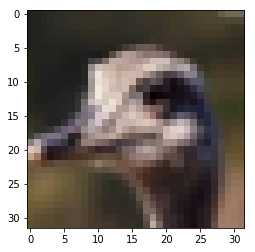

In [7]:
img, y = train_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

dog


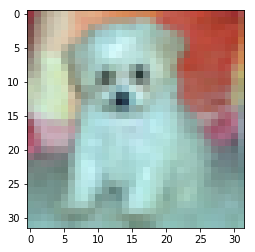

In [8]:
img, y = test_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

# Training and evaluation tools

In [9]:
def train(model, device, train_loader, optimizer, criterion, n_epochs, log_interval):
    model.train()
    for epoch in tqdm_notebook(range(n_epochs), desc = 'Epochs'):
        for batch_idx, (X, y) in tqdm_notebook(enumerate(train_loader), total = len(train_loader), desc = 'Batches', leave = False):
            X, y       = X.to(device), y.to(device)
            optimizer.zero_grad()
            *_, y_pred = model(X)
            loss       = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f'Train epoch {epoch}: [{batch_idx * len(X):5d}/{len(train_loader.dataset):5d}] Loss: {loss.item():7.4f}')

In [10]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_set_size = len(test_loader.dataset)
    correct_answers = 0
    sum_loss = 0
    with torch.no_grad():
        for X, y in tqdm_notebook(test_loader):
            X, y             = X.to(device), y.to(device)
            *_, y_pred       = model(X)
            class_pred       = y_pred.argmax(dim = 1)
            correct_answers += (y == class_pred).sum().item()
            sum_loss        += criterion(y_pred, y).item()
    accuracy = correct_answers / test_set_size
    average_loss = sum_loss / len(test_loader)
    
    return accuracy, average_loss

# Model

In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3 , 16 , 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 16 , 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32,  3, padding = 1)
        self.conv4 = nn.Conv2d(32, 32,  3, padding = 1)
        self.fc1   = nn.Linear(32 * 8 * 8, 128)
        self.fc2   = nn.Linear(128      , 10)
        
    def forward(self, x):
        out_conv1 = F.dropout(F.relu(self.conv1(x)), 0.2)
        out_conv2 = F.dropout(F.relu(self.conv2(out_conv1)), 0.2)
        out_pool1 = F.max_pool2d(out_conv2, kernel_size = (2, 2))
        out_conv3 = F.dropout(F.relu(self.conv3(out_pool1)), 0.2)
        out_conv4 = F.dropout(F.relu(self.conv4(out_conv3)), 0.2)
        out_pool2 = F.max_pool2d(out_conv4, kernel_size = (2, 2))
        out_view  = out_pool2.view(-1, 32 * 8 * 8)
        out_fc    = F.dropout(F.relu(self.fc1(out_view)), 0.2)
        out       = self.fc2(out_fc)
        
        return out_conv1, out_conv2, out_conv3, out_conv4, out

# Training

In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
if do_train:
    cnn       = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters())
    train(cnn, device, train_loader, optimizer, criterion, 15, len(train_loader) // 5)
    torch.save(cnn.state_dict(), model_path)

Train epoch 0: [    0/50000] Loss:  2.2975
Train epoch 0: [ 9984/50000] Loss:  2.0181
Train epoch 0: [19968/50000] Loss:  1.4788
Train epoch 0: [29952/50000] Loss:  1.3267
Train epoch 0: [39936/50000] Loss:  1.3801
Train epoch 0: [31200/50000] Loss:  1.2854


Train epoch 1: [    0/50000] Loss:  1.3317
Train epoch 1: [ 9984/50000] Loss:  1.2682
Train epoch 1: [19968/50000] Loss:  1.4135
Train epoch 1: [29952/50000] Loss:  1.1692
Train epoch 1: [39936/50000] Loss:  1.2378
Train epoch 1: [31200/50000] Loss:  1.1663


Train epoch 2: [    0/50000] Loss:  1.0399
Train epoch 2: [ 9984/50000] Loss:  1.1264
Train epoch 2: [19968/50000] Loss:  1.1439
Train epoch 2: [29952/50000] Loss:  1.0971
Train epoch 2: [39936/50000] Loss:  1.1082
Train epoch 2: [31200/50000] Loss:  1.0212


Train epoch 3: [    0/50000] Loss:  1.0157
Train epoch 3: [ 9984/50000] Loss:  1.0893
Train epoch 3: [19968/50000] Loss:  1.0255
Train epoch 3: [29952/50000] Loss:  1.1398
Train epoch 3: [39936/50000] Loss:  1.0505
Train epoch 3: [31200/50000] Loss:  1.0060


Train epoch 4: [    0/50000] Loss:  1.0218
Train epoch 4: [ 9984/50000] Loss:  0.8468
Train epoch 4: [19968/50000] Loss:  0.9512
Train epoch 4: [29952/50000] Loss:  1.0514
Train epoch 4: [39936/50000] Loss:  1.0520
Train epoch 4: [31200/50000] Loss:  1.1419


Train epoch 5: [    0/50000] Loss:  0.8202
Train epoch 5: [ 9984/50000] Loss:  0.8945
Train epoch 5: [19968/50000] Loss:  0.8717
Train epoch 5: [29952/50000] Loss:  0.8963
Train epoch 5: [39936/50000] Loss:  0.9203
Train epoch 5: [31200/50000] Loss:  0.8534


Train epoch 6: [    0/50000] Loss:  0.9211
Train epoch 6: [ 9984/50000] Loss:  0.9229
Train epoch 6: [19968/50000] Loss:  0.9517
Train epoch 6: [29952/50000] Loss:  0.7986
Train epoch 6: [39936/50000] Loss:  0.7528
Train epoch 6: [31200/50000] Loss:  0.7137


Train epoch 7: [    0/50000] Loss:  1.0018
Train epoch 7: [ 9984/50000] Loss:  0.7469
Train epoch 7: [19968/50000] Loss:  0.7448
Train epoch 7: [29952/50000] Loss:  0.8167
Train epoch 7: [39936/50000] Loss:  0.7484
Train epoch 7: [31200/50000] Loss:  1.0758


Train epoch 8: [    0/50000] Loss:  0.8741
Train epoch 8: [ 9984/50000] Loss:  0.7672
Train epoch 8: [19968/50000] Loss:  0.7184
Train epoch 8: [29952/50000] Loss:  0.7459
Train epoch 8: [39936/50000] Loss:  0.7186
Train epoch 8: [31200/50000] Loss:  0.6792


Train epoch 9: [    0/50000] Loss:  0.7669
Train epoch 9: [ 9984/50000] Loss:  0.7715
Train epoch 9: [19968/50000] Loss:  0.7215
Train epoch 9: [29952/50000] Loss:  0.8024
Train epoch 9: [39936/50000] Loss:  0.7917
Train epoch 9: [31200/50000] Loss:  0.8207


Train epoch 10: [    0/50000] Loss:  0.7111
Train epoch 10: [ 9984/50000] Loss:  0.6560
Train epoch 10: [19968/50000] Loss:  0.8953
Train epoch 10: [29952/50000] Loss:  0.7403
Train epoch 10: [39936/50000] Loss:  0.7109
Train epoch 10: [31200/50000] Loss:  0.8320


Train epoch 11: [    0/50000] Loss:  0.4995
Train epoch 11: [ 9984/50000] Loss:  0.7650
Train epoch 11: [19968/50000] Loss:  0.7841
Train epoch 11: [29952/50000] Loss:  0.7127
Train epoch 11: [39936/50000] Loss:  0.5546
Train epoch 11: [31200/50000] Loss:  0.8928


Train epoch 12: [    0/50000] Loss:  0.6876
Train epoch 12: [ 9984/50000] Loss:  0.7643
Train epoch 12: [19968/50000] Loss:  0.6605
Train epoch 12: [29952/50000] Loss:  0.4367
Train epoch 12: [39936/50000] Loss:  0.6258
Train epoch 12: [31200/50000] Loss:  0.6545


Train epoch 13: [    0/50000] Loss:  0.6166
Train epoch 13: [ 9984/50000] Loss:  0.6651
Train epoch 13: [19968/50000] Loss:  0.7062
Train epoch 13: [29952/50000] Loss:  0.7736
Train epoch 13: [39936/50000] Loss:  0.6396
Train epoch 13: [31200/50000] Loss:  0.6151


Train epoch 14: [    0/50000] Loss:  0.7641
Train epoch 14: [ 9984/50000] Loss:  0.5426
Train epoch 14: [19968/50000] Loss:  0.4248
Train epoch 14: [29952/50000] Loss:  0.5336
Train epoch 14: [39936/50000] Loss:  0.7004
Train epoch 14: [31200/50000] Loss:  0.7793



In [14]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(model_path))
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
if do_eval:
    accuracy, avg_loss = evaluate(cnn, device, train_loader, criterion)
    print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    accuracy, avg_loss = evaluate(cnn, device, test_loader, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


[Train] Accuracy: 78.24%, loss:  0.6036



[Test] Accuracy: 68.64%, loss:  0.9455


Real label: 1
Predicted label: 1


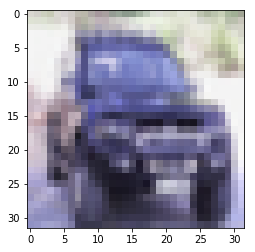

In [16]:
ex_id = 9
X, y  = test_dataset[ex_id]
X     = X.to(device)
img   = X.permute(1, 2, 0)
img   = reverse_normalize(img)
plt.imshow(img.cpu())
print(f'Real label: {y}')
print(f'Predicted label: {cnn(X.unsqueeze(0))[-1].argmax().item()}')

# Adversarial examples

In [17]:
def generate_adv_example(model, epsilon, criterion, X):
    X.requires_grad = True
    *_, y_pred      = model(X)
    loss            = criterion(y_pred, y_pred.argmax(dim = 1))
    loss.backward()
    adv_example     = X + epsilon * X.grad.sign()
    
    # Clamping the result to [0, 1] in each channel.
    # I don't think that there exist a multidimensional clamp function.
    for channel, norm_func in enumerate([normalize_red, normalize_green, normalize_blue]):
        adv_example[:, channel, ...].clamp_(norm_func(0), norm_func(1))
    
    return adv_example

In [18]:
def adv_sample_process(model, epsilon, X, y):
    source       = X.unsqueeze(0).to(device)
    *_, y_pred   = model(source)
    adv_example  = generate_adv_example(model, epsilon, criterion, source)
    *_, adv_pred = cnn(adv_example)
    for i in range(10):
        print(f'Class {i}: {y_pred[0, i]:6.4f} \t->\t {adv_pred[0, i]:^6.4f}')
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    display_img(source)
    plt.subplot(1, 2, 2)
    display_img(adv_example)
    print(f'Real label: {cifar_cats[y]}')
    print(f'Predicted label: {cifar_cats[adv_pred[0].argmax().item()]}')

Class 0: -4.6213 	->	 -2.6583
Class 1: -0.4811 	->	 -0.2846
Class 2: -1.9105 	->	 -2.5519
Class 3: 0.0356 	->	 0.4730
Class 4: -0.2857 	->	 -1.4164
Class 5: 0.9710 	->	 1.6989
Class 6: 3.0648 	->	 -0.6548
Class 7: -3.2143 	->	 -1.9086
Class 8: -3.4574 	->	 -3.0912
Class 9: -2.1182 	->	 0.8255
Real label: frog
Predicted label: dog


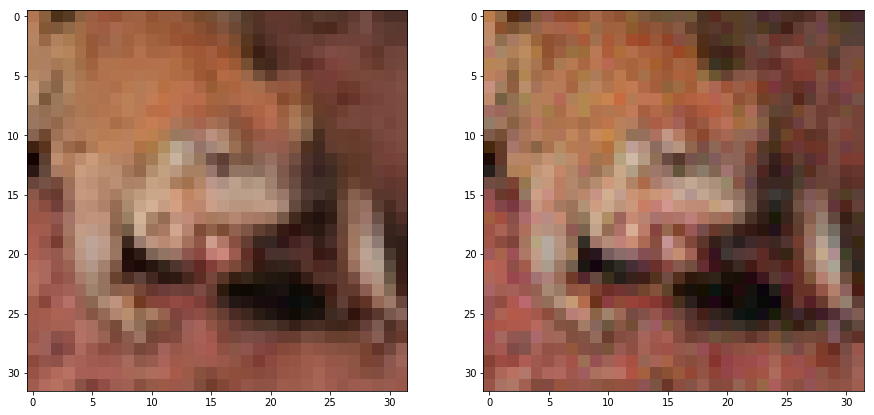

In [19]:
ex_id = 5
X, y = test_dataset[ex_id]
adv_sample_process(cnn, 0.15, X, y)

# KNN experimentations

In [20]:
conv_features = [[] for _ in range(4)]
targets       = []
predictions   = []
c = 0
#for X, y in tqdm_notebook(train_loader):
for X, y in train_loader:
    X                  = X.to(device)
    *out_convs, y_pred = cnn(X)
    for i, out_conv in enumerate(out_convs):
        conv_feat = out_conv.view(out_conv.size(0), -1).cpu().detach().numpy()
        conv_features[i].append(conv_feat)
    targets.append(y.numpy())
    predictions.append(y_pred.cpu().detach().numpy())
    if c == -1:
        break
    c += 1

In [21]:
conv_features = [np.concatenate(out_convs) for out_convs in conv_features]
targets       = np.concatenate(targets)
predictions   = np.concatenate(predictions, axis = 0)
print([conv_feat.shape for conv_feat in conv_features])
print(targets.shape)
print(predictions.shape)

[(50000, 16384), (50000, 16384), (50000, 8192), (50000, 8192)]
(50000,)
(50000, 10)


# Plots

In [22]:
X = conv_features[-1]

In [23]:
pca = PCA(n_components = 2)
X_trans = pca.fit_transform(X)

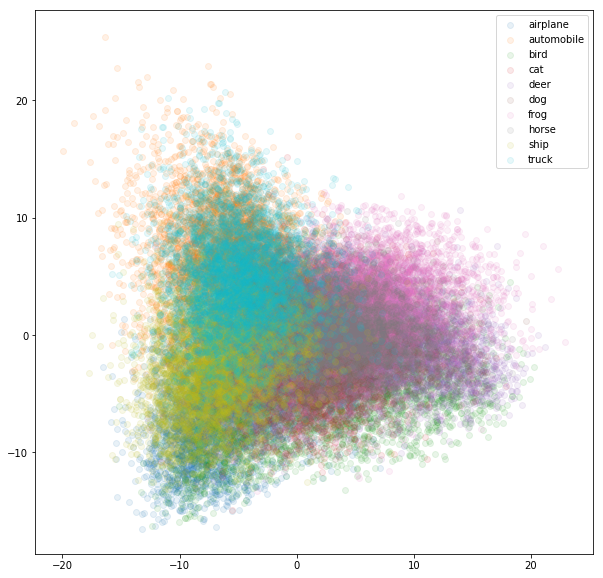

In [24]:
plt.figure(figsize = (10, 10))
for i, category in enumerate(cifar_cats):
    category_inputs = X_trans[targets == i]
    plt.scatter(category_inputs[:, 0], category_inputs[:, 1], label = category, alpha = 0.1)
plt.legend()

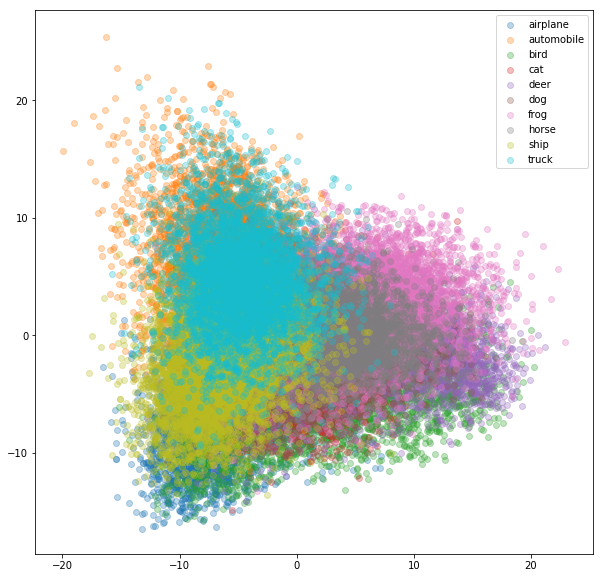

In [25]:
plt.figure(figsize = (10, 10))
for i, category in enumerate(cifar_cats):
    category_inputs = X_trans[np.argmax(predictions, axis = 1) == i]
    plt.scatter(category_inputs[:, 0], category_inputs[:, 1], label = category, alpha = 0.3)
plt.legend()

In [26]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors import NearestNeighbors

In [27]:
# X_small = X[:5]
# X_small.shape

(5, 8192)

In [28]:
# dist_mat = cosine_distances(X_small)
# dist_mat

array([[0.        , 0.9592519 , 0.9502996 , 0.9580633 , 0.92829233],
       [0.9592519 , 0.        , 0.9404427 , 0.9121104 , 0.95713747],
       [0.9502996 , 0.9404427 , 0.        , 0.94296575, 0.8952764 ],
       [0.9580633 , 0.9121104 , 0.94296575, 0.        , 0.88581336],
       [0.92829233, 0.95713747, 0.8952764 , 0.88581336, 0.        ]],
      dtype=float32)

In [29]:
# neigh = NearestNeighbors(n_neighbors = 4, metric = 'cosine')
# neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=4, p=2, radius=1.0)

In [30]:
# for i in range(len(X_small)):
#     print(*neigh.kneighbors([X_small[i]]), sep = '\n')

[[0.         0.6900035  0.71248794 0.71836615]]
[[    0 42432  9037  8787]]
[[0.        0.5579582 0.622825  0.6300424]]
[[    1  9464 16534 33291]]
[[0.         0.7496692  0.76439047 0.7662661 ]]
[[    2 13173 43889 32893]]
[[1.7881393e-07 7.3698771e-01 7.4140698e-01 7.4201107e-01]]
[[    3 44523 27408  8995]]
[[1.1920929e-07 6.5970373e-01 6.6831475e-01 6.7966390e-01]]
[[    4 28099 11211 24057]]


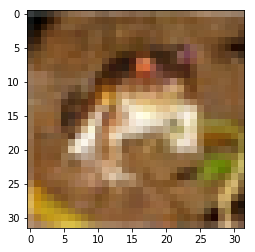

In [31]:
# display_img(train_dataset[0][0].to(device))

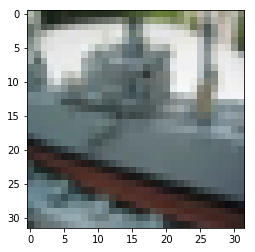

In [32]:
# display_img(train_dataset[31032][0].to(device))

In [33]:
# neigh.kneighbors([X_small[0]], return_distance = False)

array([[    0, 42432,  9037,  8787]])

In [34]:
neighs = [NearestNeighbors(n_neighbors = 5, metric = 'cosine').fit(feats) for feats in conv_features]

Predicted class: truck


tensor([[ 1.8808,  1.3183, -0.3169, -1.5542, -2.9855, -3.0926, -2.4158, -2.1034,
          2.0224,  0.5838]], device='cuda:0', grad_fn=<AddmmBackward>)

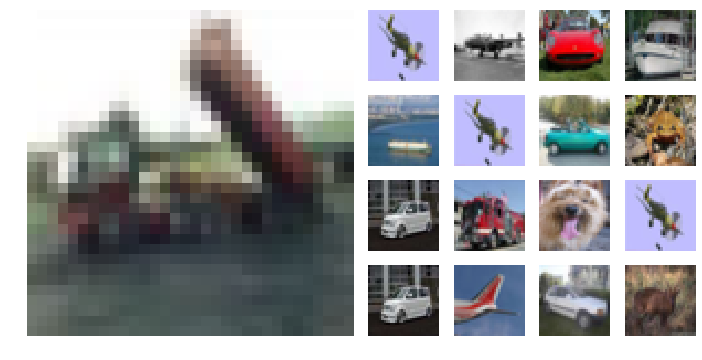

In [44]:
def display_knn_interpretation(model, X, y, train_data, neighs):
    img_data = lambda img: reverse_normalize(img.to(device).squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.figure(figsize = (12, 6))
    gs      = gridspec.GridSpec(4, 8)
    ax_big  = plt.subplot(gs[:, :-4])
    ax_grid = [[plt.subplot(gs[i, j]) for j in range(4, 8)] for i in range(4)]
    ax_big.imshow(img_data(X))
    ax_big.axis('off')
    *out_convs, y_pred = model(X.unsqueeze(0).to(device))
    for i, (neigh, layer_emb) in enumerate(zip(neighs, out_convs)):
        emb = layer_emb.detach().cpu().view(1, -1).numpy()
        neighbors = neigh.kneighbors(emb, return_distance = False) 
        for j, neighbor_id in enumerate(neighbors[0, 1:]):
            ax_grid[i][j].imshow(img_data(train_data[neighbor_id][0]))
            ax_grid[i][j].axis('off')
    print(f'Predicted class: {cifar_cats[pred.argmax(dim = 1).cpu().item()]}')
    return y_pred

display_knn_interpretation(cnn, train_dataset[2][0], 0, train_dataset, neighs)